# Calculate beam intensity and resolution vs FC freq

In [1]:
import os, numpy as np
import histogram.hdf as hh, histogram as H
import mcvine, mcvine.components, mcvine.run_script

from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
from mcni.utils import conversion as C

In [3]:
workdir = os.path.expanduser("/SNS/users/lj7/dv/sns-chops/resolution/ARCS/mcvine/Ei_100")
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/resolution/ARCS/mcvine/Ei_100


# Function

T0_nu value: see check-V-data.ipynb

Be careful to choose dE_axis. The step size should be small enough

In [13]:
def run(
    freq=600., Ei=400., T0_nu=180., E=0., Q=5., 
    dQ_axis=(-5, 5, 0.05), dE_axis=(-50, 50, .2),
):
    pwd = os.path.abspath('.')
    beam_dir = os.path.abspath('beam-FC_%s' % freq)
    os.makedirs(beam_dir)
    os.chdir(beam_dir)
    cmd = "mcvine instruments arcs beam --T0_nu=%s --E=%s --fermi_nu=%s --ncount=1e8 --nodes=20" % (
        T0_nu, Ei, freq)
    print cmd
    if os.system(cmd):
        raise RuntimeError('%s failed' % cmd)
    os.chdir(pwd)
    
    instrument = 'ARCS'
    ncount = 1e7
    nodes = 20
    from dgsres.powder import  use_ConstantQEKernel
    sim = use_ConstantQEKernel.Sim(
        instrument = instrument,
        workdir = os.path.abspath("./resolution-FC_%s" % freq),
        beamdir = beam_dir,
        Ei = Ei,
        Q = Q,
        dQ_axis=dQ_axis,
        dE_axis=dE_axis,
        ncount = ncount,
        nodes = nodes,
        )
    sim.run(E=E)
    return

In [7]:
Ei = 100.
E=0.; Q=5.
T0_nu = 120.
dQ_axis=(-3, 3, 0.02); dE_axis=(-10, 10, .05)

# Test one freq

In [9]:
run(freq=600., Ei=Ei, T0_nu=T0_nu, E=E, Q=Q, 
    dQ_axis=dQ_axis, dE_axis=dE_axis)

mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=600.0 --ncount=1e8 --nodes=20


/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/histogram/hdf/Loader.py:129: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'storage' in list(dataGroup): # this uses the 'storage' convention


<IPython.core.display.Javascript object>


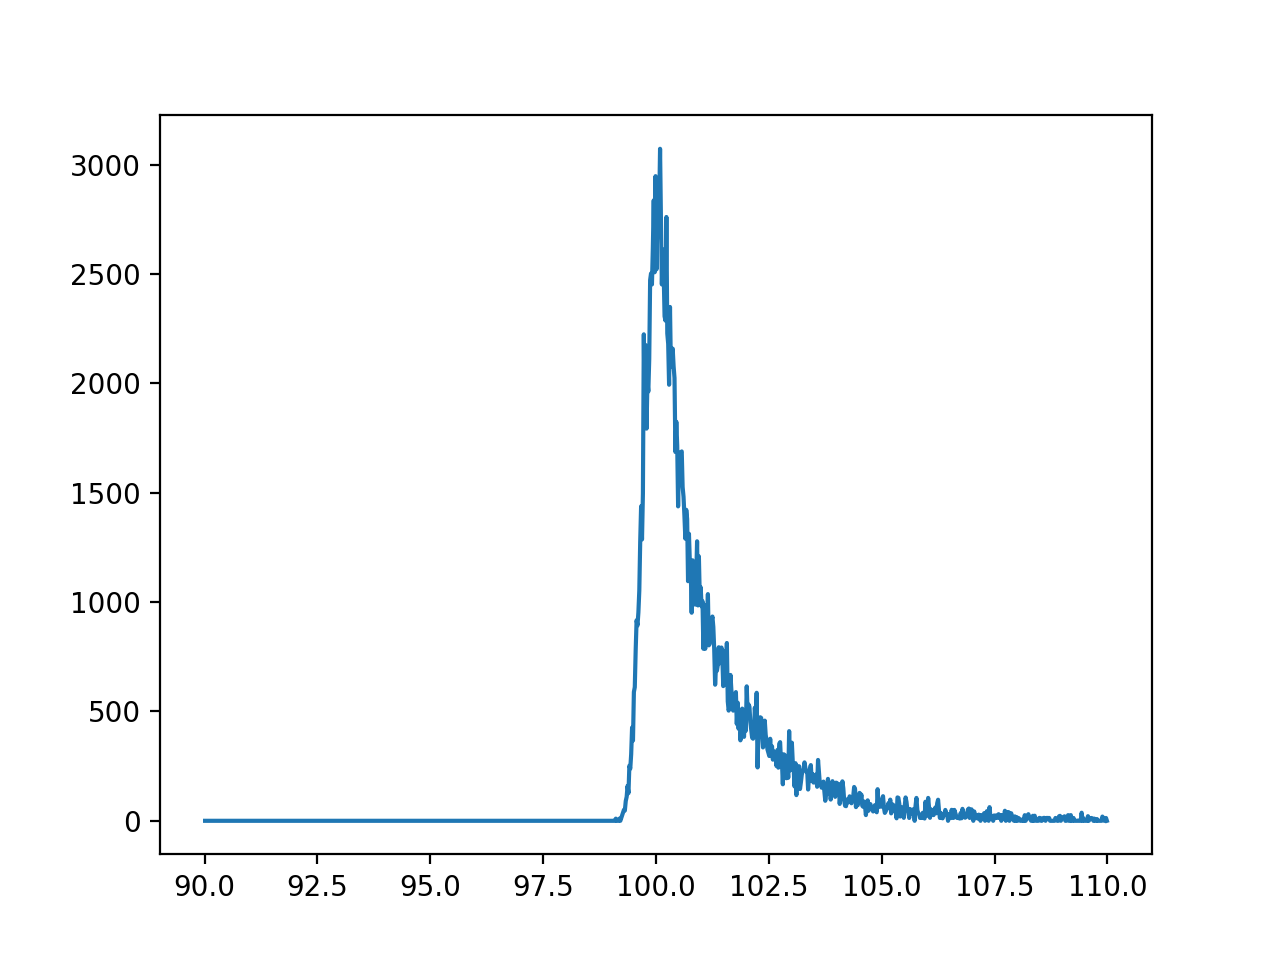

In [11]:
ie = hh.load("beam-FC_600.0/out/ienergy.h5")
plt.figure()
plt.plot(ie.energy, ie.I)

<IPython.core.display.Javascript object>


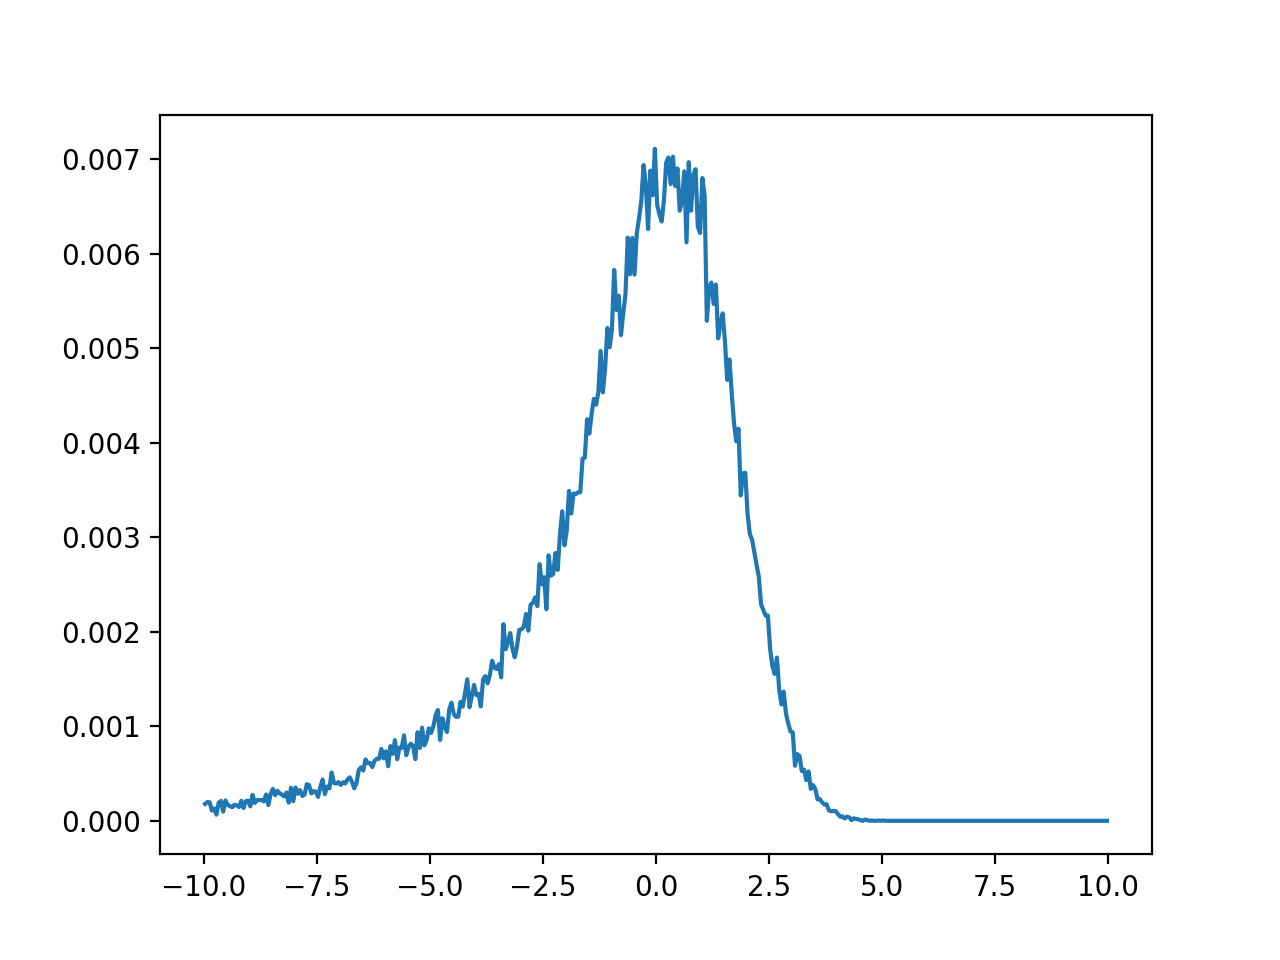

In [12]:
ie = hh.load("./resolution-FC_600.0/out/ie-Q_5.0-E_0.0.h5")
plt.figure()
plt.plot(ie.E, ie.I)

# Run all freqs

In [14]:
freqs = np.arange(60., 541., 60.)

In [15]:
%%time
for freq in freqs:
    print freq
    run(freq=freq, Ei=Ei, T0_nu=T0_nu, E=E, Q=Q, 
        dQ_axis=dQ_axis, dE_axis=dE_axis)

60.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=60.0 --ncount=1e8 --nodes=20
120.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=120.0 --ncount=1e8 --nodes=20
180.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=180.0 --ncount=1e8 --nodes=20
240.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=240.0 --ncount=1e8 --nodes=20
300.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=300.0 --ncount=1e8 --nodes=20
360.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=360.0 --ncount=1e8 --nodes=20
420.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=420.0 --ncount=1e8 --nodes=20
480.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=480.0 --ncount=1e8 --nodes=20
540.0
mcvine instruments arcs beam --T0_nu=120.0 --E=100.0 --fermi_nu=540.0 --ncount=1e8 --nodes=20
CPU times: user 1.16 s, sys: 267 ms, total: 1.43 s
Wall time: 3h 25min 35s


# Gather resolution and intensity data

## Resolution

In [16]:
freqs = np.arange(60., 601., 60.)

In [17]:
FWHMs = []
for freq in freqs:
    fn = 'resolution-FC_%s/out/ie-Q_%s-E_%s.h5' % (freq, Q, E)
    h = hh.load(fn)
    Is = h.I
    Es = h.E
    maxI = np.max(Is)
    upper = Es[Is > maxI/2.]
    FWHM = upper[-1] - upper[0]
    print FWHM
    FWHMs.append(FWHM)

9.95
6.8
5.75
5.55
5.2
5.0
4.6
4.4
4.0
3.6


<IPython.core.display.Javascript object>


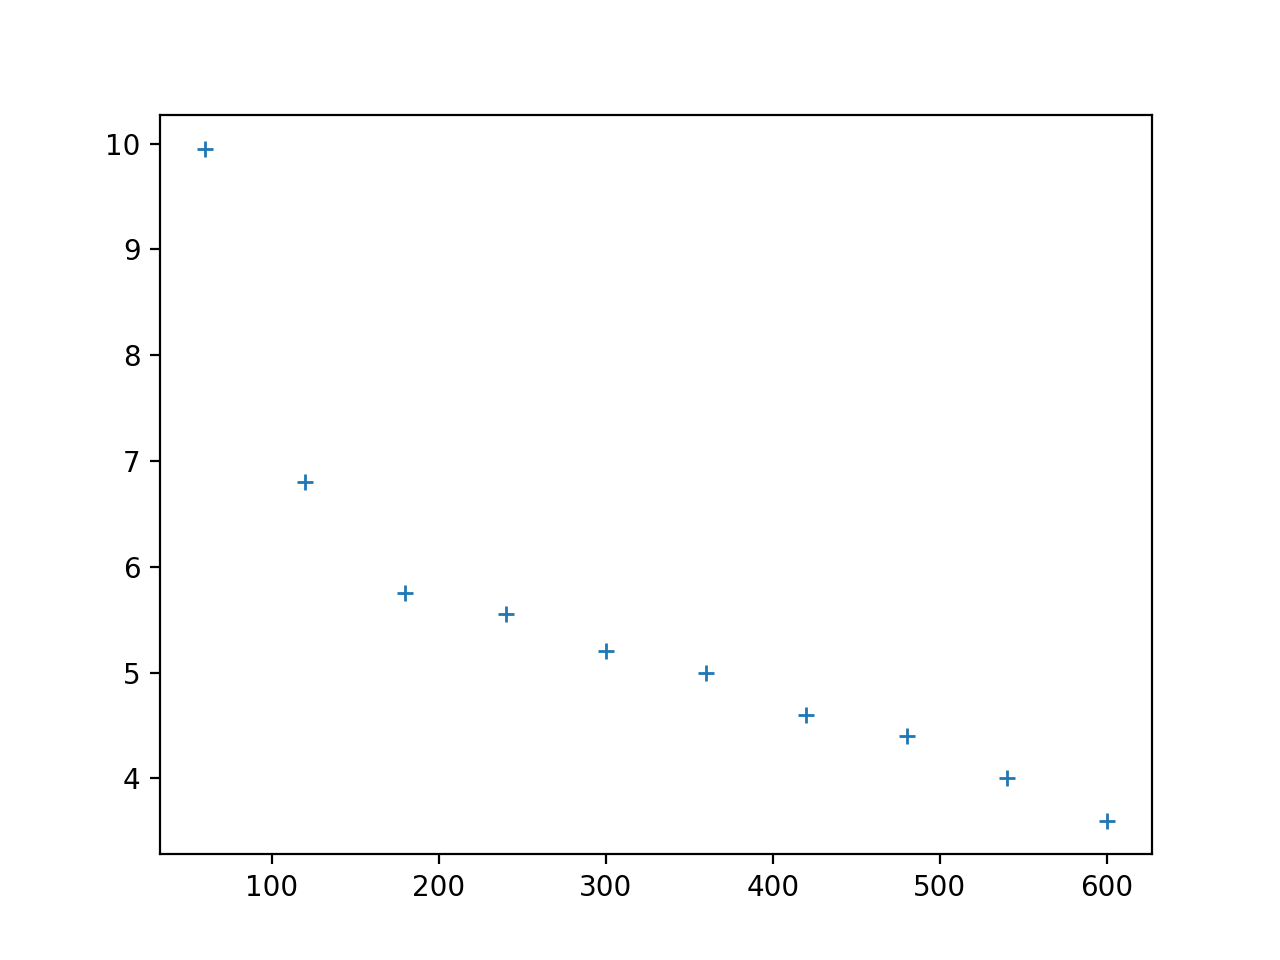

In [18]:
plt.figure()
plt.plot(freqs, FWHMs, '+')

The data at lower freq is large. Inspect

<IPython.core.display.Javascript object>


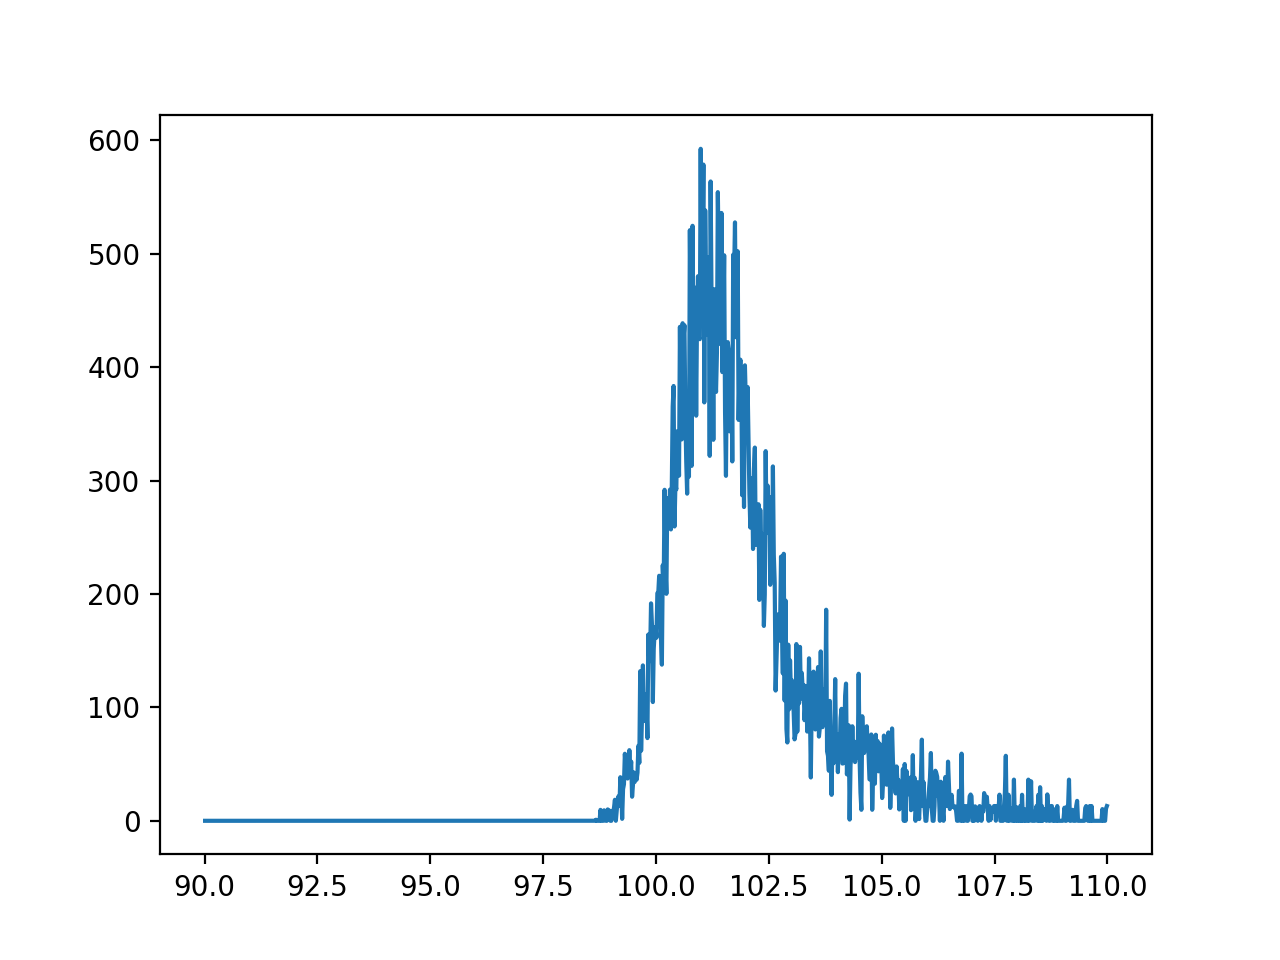

In [19]:
h = hh.load('beam-FC_60.0/out/ienergy.h5')
plt.figure()
plt.plot(h.energy, h.I)

<IPython.core.display.Javascript object>


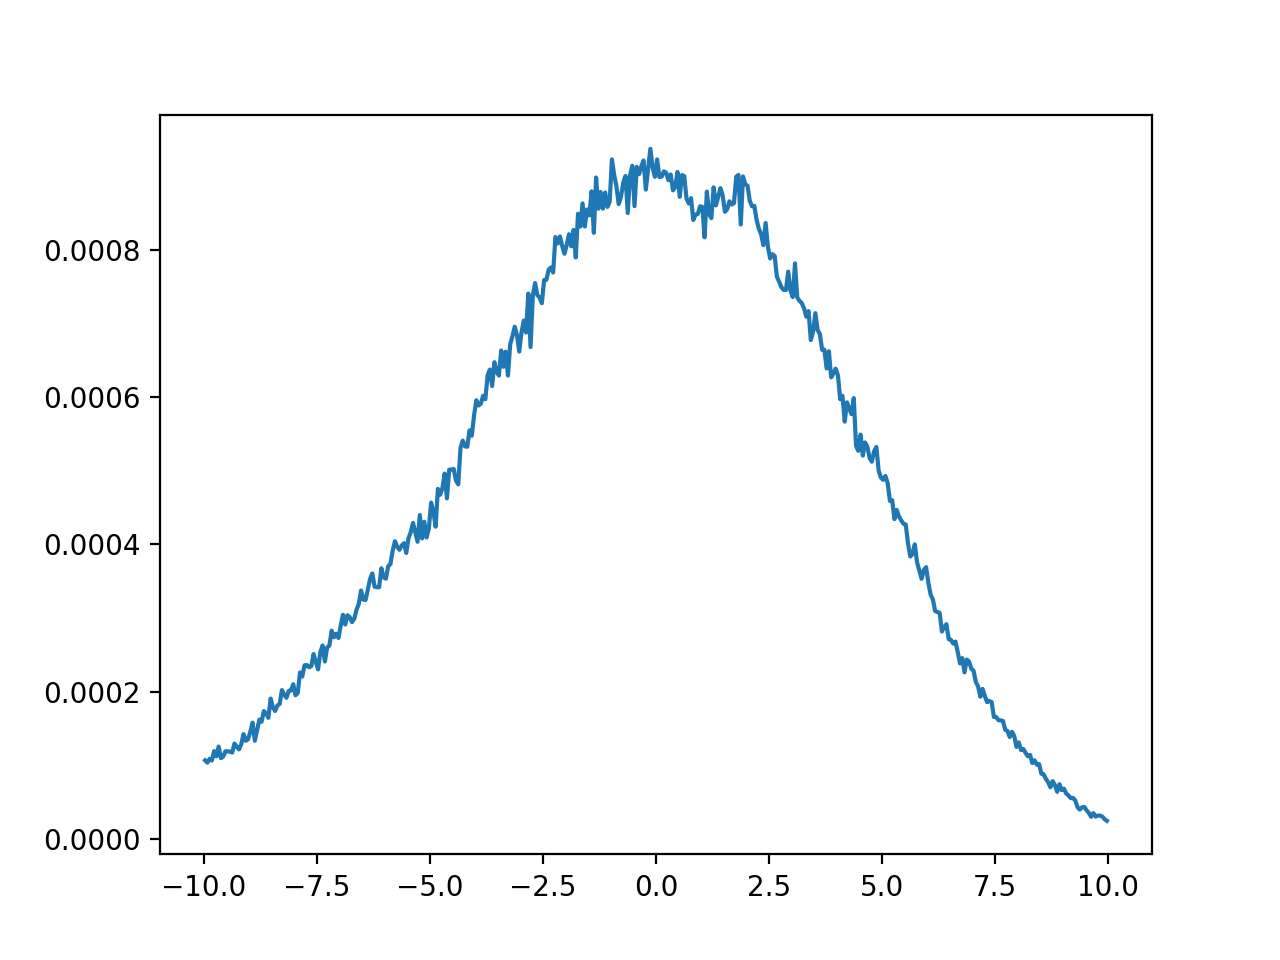

In [20]:
h = hh.load('resolution-FC_60.0/out/ie-Q_5.0-E_0.0.h5')
plt.figure()
plt.plot(h.E, h.I)

## Intensity

In [21]:
counts = []
for freq in freqs:
    fn = 'beam-FC_%s/out/ienergy.h5' % (freq,)
    h = hh.load(fn)
    counts.append(h.I.sum())

<IPython.core.display.Javascript object>


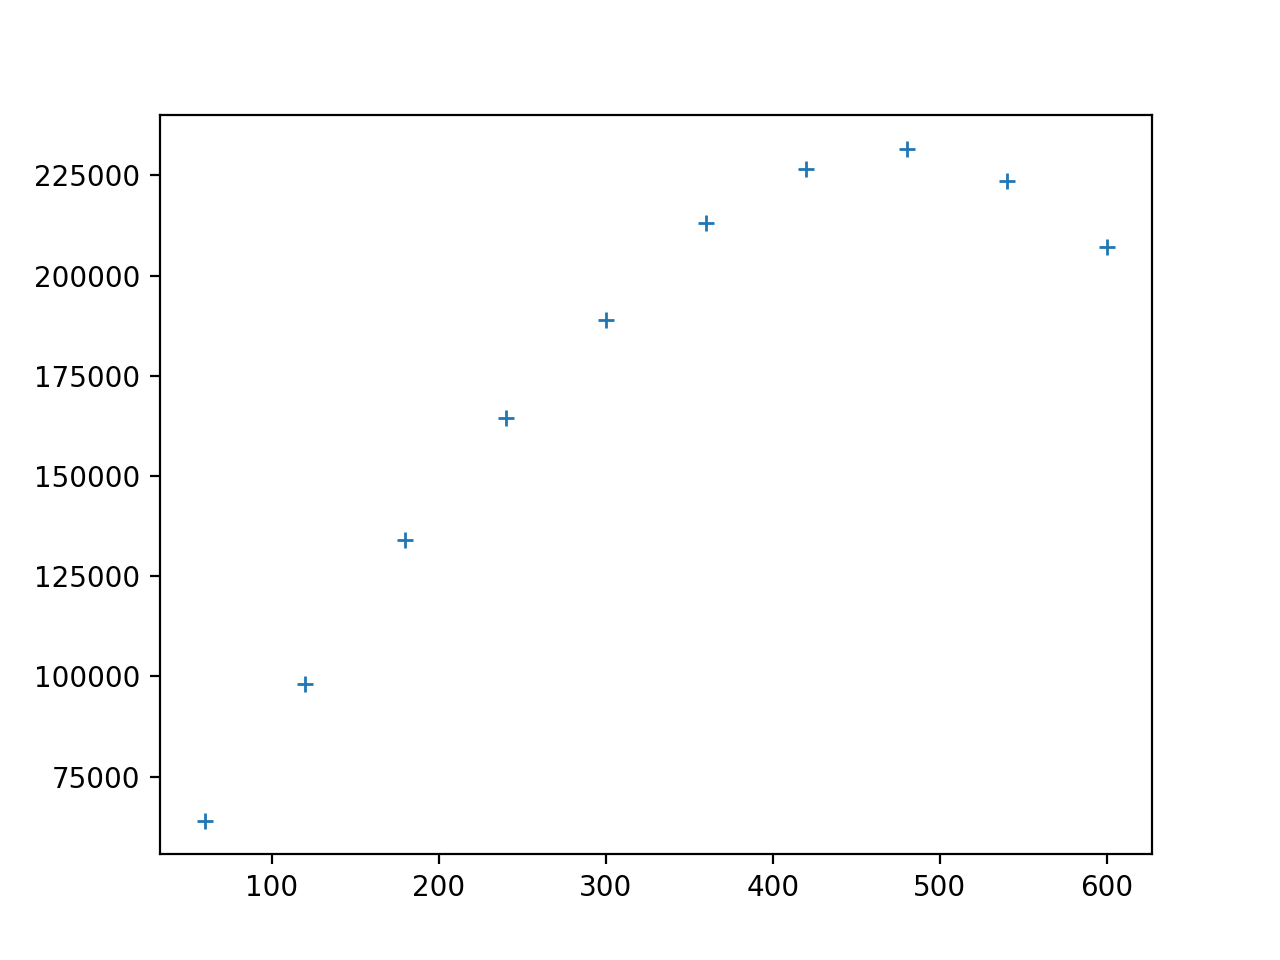

In [22]:
plt.figure()
plt.plot(freqs, counts, '+')